In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

dilated


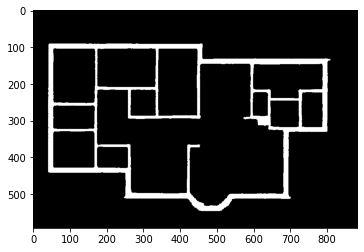

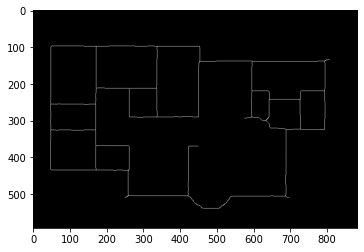

[((792, 139), (595, 139)), ((205, 98), (138, 98)), ((452, 98), (277, 98)), ((48, 353), (48, 100)), ((496, 139), (452, 139)), ((137, 97), (51, 97)), ((276, 97), (206, 97)), ((793, 138), (773, 138)), ((594, 138), (497, 138)), ((402, 290), (263, 290)), ((261, 289), (261, 212)), ((594, 237), (594, 143)), ((169, 255), (49, 255)), ((687, 448), (687, 324)), ((47, 432), (47, 354)), ((638, 219), (610, 219)), ((687, 506), (687, 474)), ((260, 434), (50, 434)), ((793, 213), (793, 137)), ((592, 291), (593, 238)), ((47, 330), (47, 297)), ((791, 324), (730, 324)), ((337, 132), (337, 99)), ((449, 256), (449, 200)), ((275, 212), (219, 212)), ((726, 242), (641, 242)), ((450, 154), (450, 144)), ((335, 212), (276, 212)), ((335, 213), (336, 140)), ((328, 97), (311, 97)), ((170, 428), (170, 226)), ((420, 504), (257, 504)), ((792, 219), (728, 219)), ((609, 219), (595, 219)), ((681, 321), (645, 320)), ((422, 505), (422, 371)), ((420, 503), (421, 466)), ((218, 212), (172, 211)), ((729, 323), (713, 323)), ((194

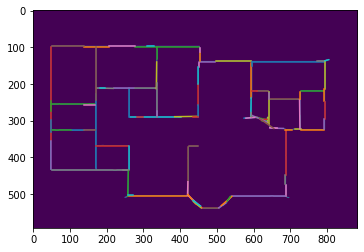

True

In [11]:
img = cv.imread("walls.png", cv.IMREAD_GRAYSCALE)
wallPixels = (cv.threshold(img, 0, 255, cv.THRESH_OTSU)[1])
dilated = cv.dilate(img, np.ones((3, 3)))
plt.imshow(wallPixels, cmap="gray")
print("dilated")
plt.imshow(dilated, cmap="gray")
plt.show()
skeleton = cv.ximgproc.thinning(dilated)

plt.imshow(skeleton, cmap="gray")
plt.show()

# lines = cv.HoughLinesP(skeleton, rho=1, theta=np.pi-180, threshold=1, maxLineGap=10)

from skimage.transform import probabilistic_hough_line
lines = probabilistic_hough_line(skeleton, threshold=10, line_length=10, line_gap=20)
print(lines)

fig, ax = plt.subplots()
ax.imshow(skeleton)

# im = np.expand_dims(skeleton, axis=2).repeat(3, axis=2) 
for line in lines:
    p0, p1 = line
    ax.plot((p0[0], p1[0]), (p0[1], p1[1]))
    # x1, y1, x2, y2 = line[0]
    # im = cv.line(im, (x1, y1), (x2, y2), (255, 0, 0), 3)
plt.show()
# plt.imshow(im)

cv.imwrite('skeleton.png', skeleton)


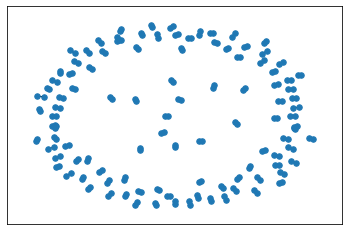

In [100]:
import networkx as nx

G = nx.Graph()

for line in lines:
    p0, p1 = line
    G.add_node(p0)
    G.add_node(p1)
    G.add_edge(p0, p1)

# print(len(lines)*2)
nx.draw_networkx(G, with_labels = False, node_size = 30)
plt.show()

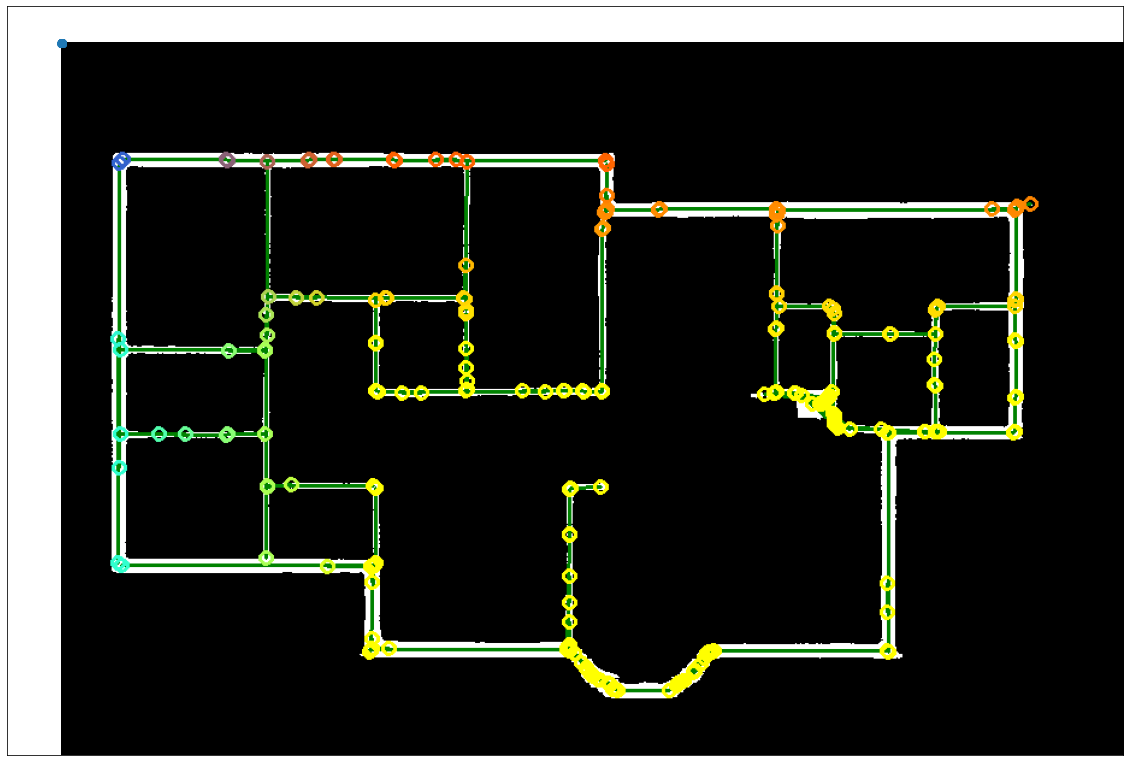

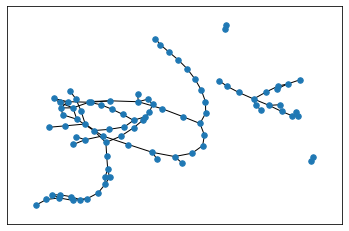

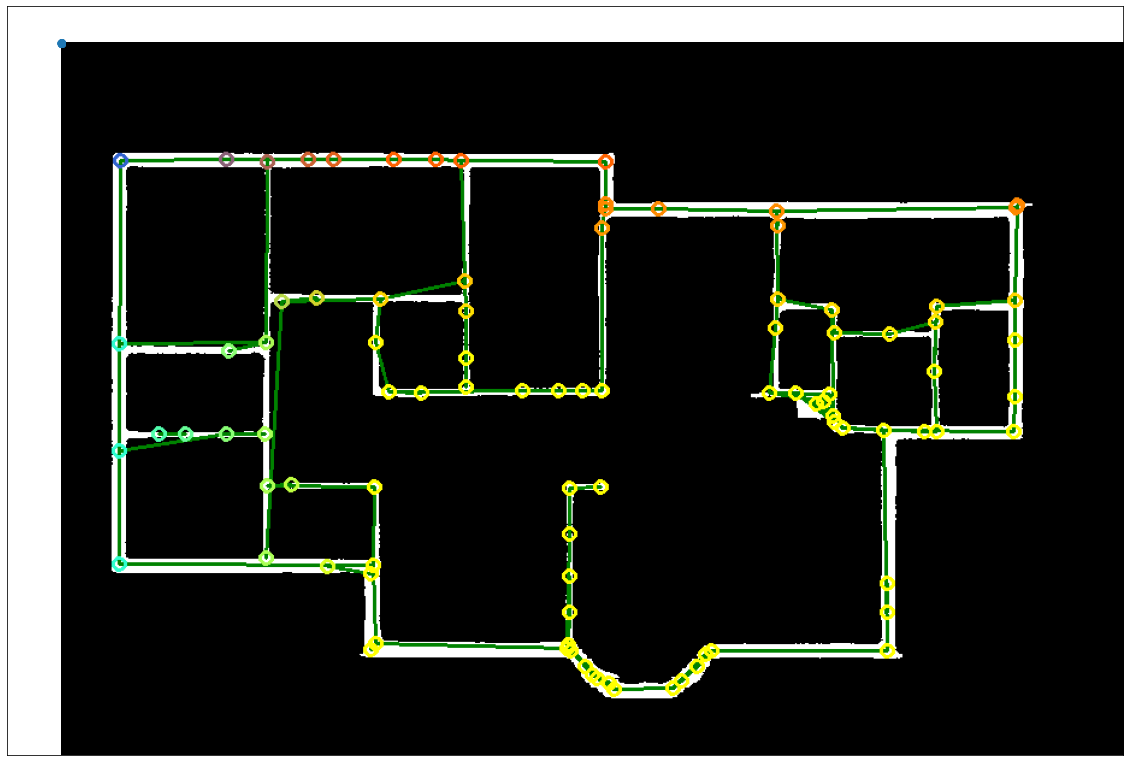

In [98]:
# g1 = G.copy()

# draw_g(g1)
# for node in g1.nodes:
#     edges = g1.edges(node)
#     if len(edges) == 1:
#         edges = list(edges)
#         closest = min((n for n in g1.nodes if n != edges[0][0] and n != edges[0][1]), key=lambda n: distance(n, node))

#         if distance(np.array(node), np.array(closest)) < 30:
#             g1 = nx.contracted_nodes(g1, node, closest, self_loops=False)
#             new_node = tuple((np.array(node)+np.array(closest))/2)
#             g1 = nx.relabel_nodes(g1, {node: new_node})

# nx.draw_networkx(g1, with_labels = False, node_size = 30)
# draw_g(g1)

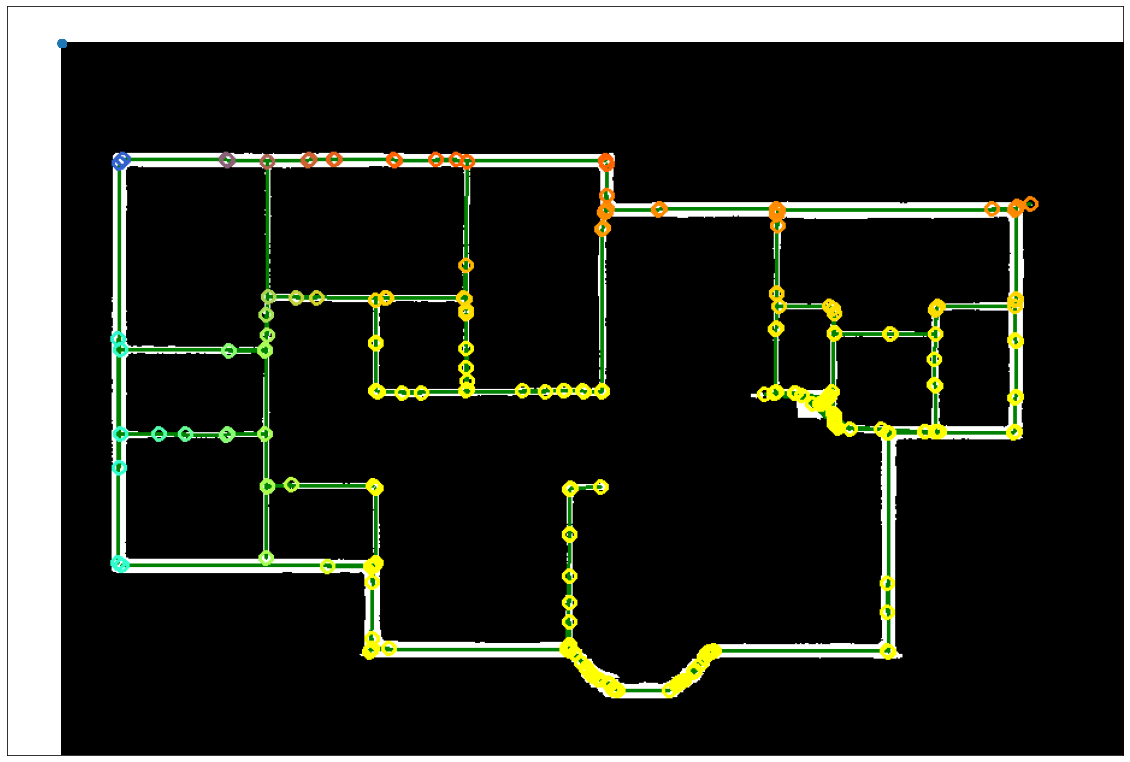

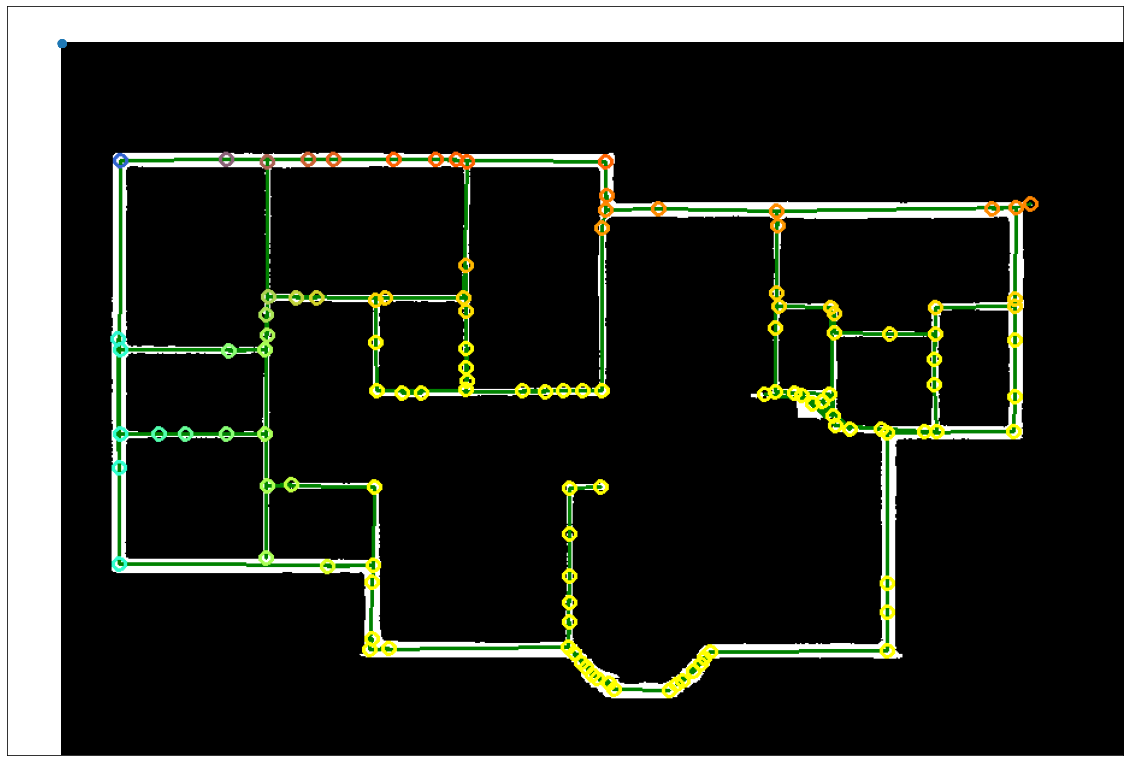

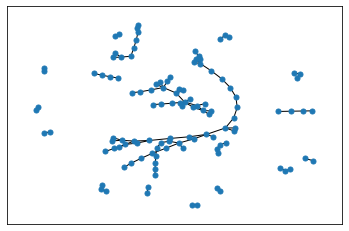

In [110]:
g1 = G.copy()
draw_g(g1)
redo = True

while redo:
    redo = False
    closest = None
    min_distance = np.inf

    for n1 in g1.nodes:
        for n2 in g1.nodes:
            dist = distance(np.array(n1), np.array(n2))
            if n1 != n2 and dist < min_distance:
                closest = n1, n2
                min_distance = dist

    if closest != None and min_distance < 5:
        n1, n2 = closest
        g1 = nx.contracted_nodes(g1, n1, n2, self_loops=False)
        new_node = tuple((np.array(n1)+np.array(n2))/2)
        g1 = nx.relabel_nodes(g1, {n1: new_node})
        # print(n1, n2, new_node)
        # nx.draw_networkx(g1, with_labels = False, node_size = 25)
        # draw_g(g1, [new_node])
        redo = True

    # if len(edges) == 1:
        # closest = min((n for n in g1.nodes if n != edges[0][0] and n != edges[0][1]), key=lambda n: distance(n, node))
draw_g(g1)
nx.draw_networkx(g1, with_labels = False, node_size = 25)

In [47]:
import numpy as np

def distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def cos_sim(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

def conditionA(p1, p2, delta=0):
    return distance(p1, p2) < delta
    
def checkConditionA(points):
    for i in range(len(points)-1):
        if conditionA(points[i], points[i+1]):
            return True
    return False

def checkConditionB(points):
    for i in range(len(points)-2):
        if conditionB(points[i], points[i+1], points[i+2]):
            return True
    return False

def conditionB(p0, p1, p2, delta=np.cos(np.radians(10))):
    if np.linalg.norm(p1 - p0) == 0 or np.linalg.norm(p2 - p1) == 0:
        return False # HACK: this might happen because, it is fixed on the wall step
    return np.abs(cos_sim(p1 - p0, p2 - p1)) > delta

def simplifyPolygon(p):
    p = np.copy(p)
    
    # a
    redo = True
    while redo:
        redo = False
        for i in range(len(p)-1):  
            if conditionA(p[i], p[i+1]):
                p[i] = (p[i] + p[i+1])/2
                p = np.delete(p, i+1, 0)
                redo = True
                break
    
    # b
    redo = True
    while redo:
        redo =  False
        for i in range(len(p)-2):
            if conditionB(p[i], p[i+1], p[i+2]):
                print(p[i], p[i+1], p[i+2])
                p = np.delete(p, i+1, 0)
                redo = True
                break
    return p

In [48]:
# Room contour optimization
# for i, _ in enumerate(final):
#     print(i)
#     drawContours(final, i)
#     while checkConditionA(final[i]) or checkConditionB(final[i]):
#         # TODO: optimize...
#         final[i] = simplifyPolygon(final[i])
#         drawContours(final, i)


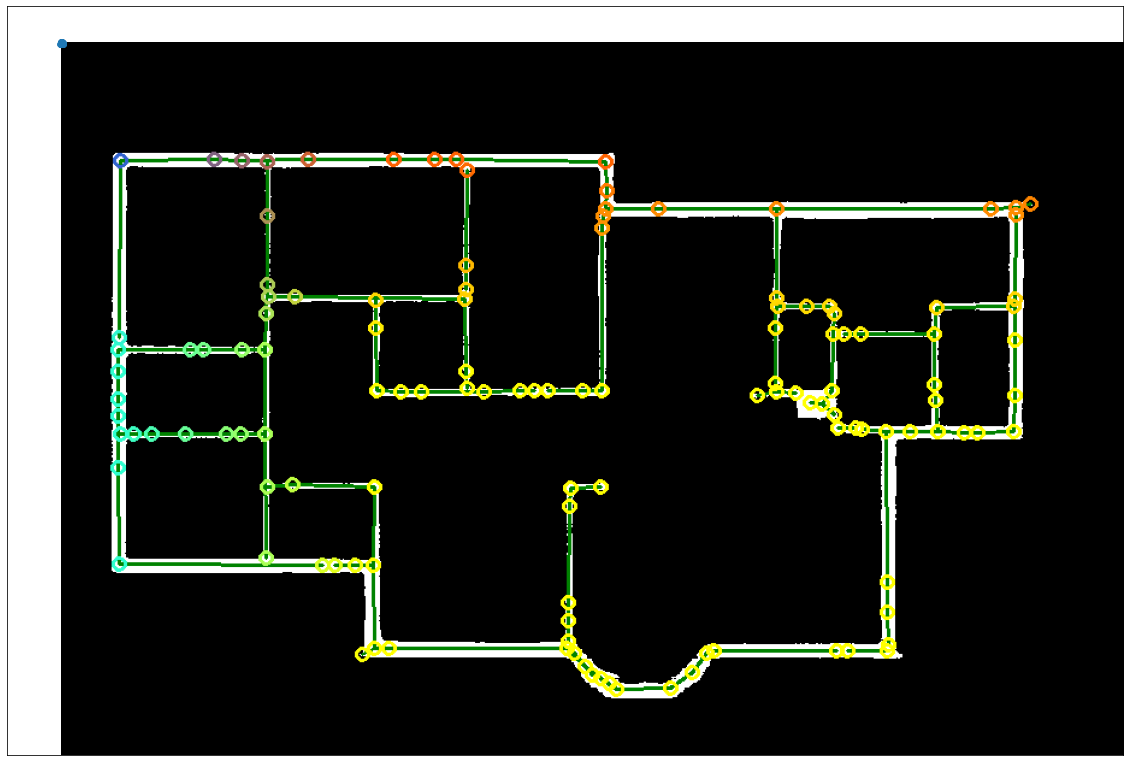

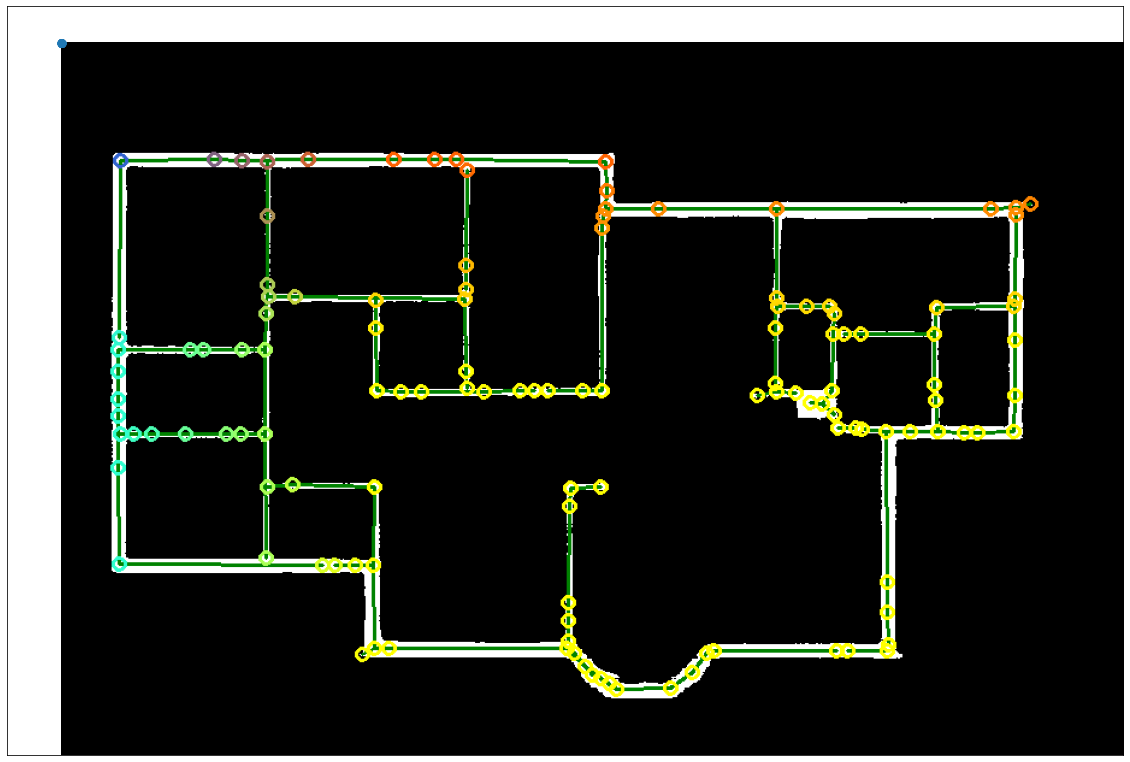

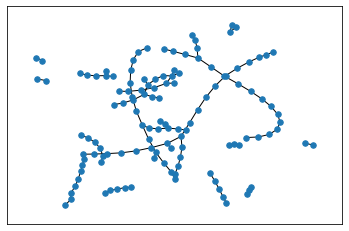

In [74]:
def draw_g(g, nodes_changed=None, edges_changed=None):
    im = np.expand_dims(wallPixels, axis=2).repeat(3, axis=2) 

    for e in g.edges:
        if edges_changed != None and e in edges_changed:
            im = cv.line(im, np.intp(e[0]), np.intp(e[1]), color=(130, 130, 0), thickness=2)
        else:
            im = cv.line(im, np.intp(e[0]), np.intp(e[1]), color=(0, 130, 0), thickness=2)

    for n in g.nodes:
        if nodes_changed != None and n in nodes_changed:
            im = cv.circle(im, np.intp(n), color=(255, 0, 0), radius=5, thickness=2)
        else:
            im = cv.circle(im, np.intp(n), color=(*tuple(int(e) for e in n), 255-int(n[0])), radius=5, thickness=2)

    plt.figure(figsize = (20,20))
    plt.imshow(im)
    nx.draw_networkx(g, with_labels = False, node_size = 30)
    plt.show()

def conditionX(n1, n2, delta=5):
    return distance(n1, n2) < delta

def conditionY(n, e, delta=500):
    p1, p2 = e
    p1, p2 = np.array(p1), np.array(p2)
    n = np.array(n)
    v1 = p1 - n
    v2 = p2 - n
    
    if np.dot(v1, v2) > 0: # if same direction
        return False
    
    return np.abs(np.cross(p2-p1,n-p1)/np.linalg.norm(p2-p1)) < delta    


def simplifyWalls(g, verbose=True):
    g = g.copy()
    
    # x
    redo = True
    while redo:
        redo = False
        contracted = False
        for i, n1 in enumerate(g.nodes):
            for j, n2 in enumerate(g.nodes):
                if i == j:
                    continue
                
                if conditionX(n1, n2):
                    g = nx.contracted_nodes(g, n1, n2, self_loops=False)
                    new_node = ((n1[0]+n2[0])/2, ((n1[1]+n2[1])/2))
                    g = nx.relabel_nodes(g, {n1: new_node})

                    contracted = True
                    redo = True
                    break
            
            if contracted:
                if verbose:
                    print("condition x:", n1, n2)
                    draw_g(g, [new_node])

                contracted = False
                break
    
    # y
    # redo = True
    # while redo:
    #     redo = False
    #     contracted = False
    #     for e in g.edges:
    #         for n in g.nodes:
    #             if n in e: # if the node is connected to the edge
    #                 continue
                
    #             if conditionY(n, e):
    #                 g.remove_edge(e[0], e[1])
    #                 g.add_edge(n, e[0])
    #                 g.add_edge(n, e[1])

    #                 contracted = True
    #                 redo = True
    #                 break
            
    #         if contracted:
    #             if verbose:
    #                 print("condition y:", e, n)
    #                 draw_g(g, [n], [(n, e[0]), (n, e[1])])
    #             contracted = False
    #             break
    
    return g

draw_g(G)
# Center line optimization
while True:#checkConditionX(G) or checkConditionY(G):
    G = simplifyWalls(G, verbose=False)
    break
draw_g(G)
nx.draw_networkx(G, with_labels = False, node_size = 30)
plt.show()

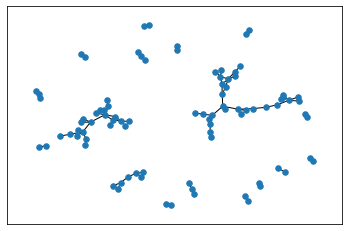

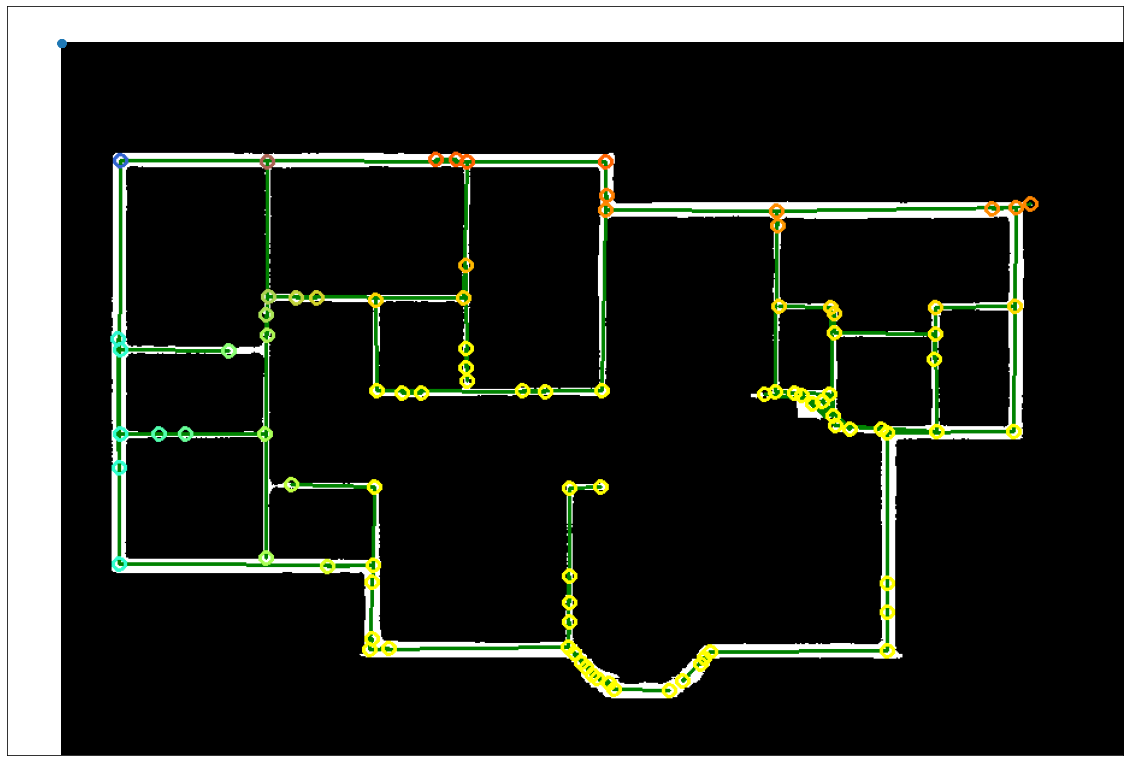

In [113]:
g2 = g1.copy()
repeat = True
while repeat:
    repeat = False
    for node in g2.nodes:
        edges = g2.edges(node)
        if len(edges) == 2:
            edges = list(edges)
            assert edges[0][0] == edges[1][0]
            p1, p2, p3 = edges[0][1], node, edges[1][1]
            if conditionB(np.array(p1), np.array(p2), np.array(p3)):
                g2.remove_node(node)
                g2.add_edge(p1, p3)
                repeat = True
                break

nx.draw_networkx(g2, with_labels = False, node_size = 30)
plt.show()
draw_g(g2)

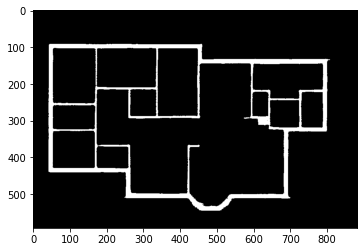

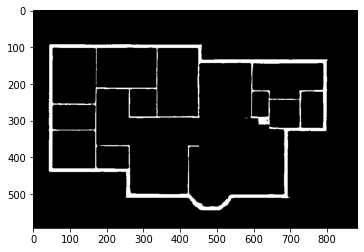

In [15]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

doors = cv.imread("walls.png")
doors_gray = cv.cvtColor(doors, cv.COLOR_BGR2GRAY)
doors_thresh = cv.threshold(doors_gray, 0, 255, cv.THRESH_OTSU)[1]
eroded = cv.erode(doors_thresh, np.ones((3, 3))) # hack, should iterate over walls and create masks with doors

plt.imshow(doors_gray, cmap="gray")
plt.show()

plt.imshow(eroded, cmap="gray")
plt.show()

In [ ]:
import recognition

recognition.get_opening_lines()

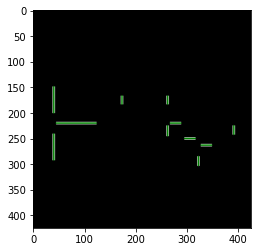

In [10]:
door_cnts, _ = cv.findContours(eroded, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

def boxToLine(box):
    if distance(box[0], box[1]) > distance(box[1], box[2]):
        return np.array([(box[0] + box[3])/2, (box[1] + box[2])/2])
    else:
        return np.array([(box[0] + box[1])/2, (box[2] + box[3])/2])

## DISPLAY
im = np.expand_dims(eroded, axis=2).repeat(3, axis=2)
for k, cnt in enumerate(door_cnts):
    rect = cv.minAreaRect(cnt)
    box = cv.boxPoints(rect)
    
    line = np.int0(boxToLine(np.int0(box)))
    
    im = cv.line(im, line[0], line[1], color=(0, 130, 0), thickness=2)
    
    plt.imshow(im)
plt.show()
##

lines = [np.int0(boxToLine(cv.boxPoints(cv.minAreaRect(cnt)))) for cnt in door_cnts]

In [65]:
import mystic
import scipy.spatial.distance as scidistance

walls = np.array(G.edges)

## DISPLAY
img = cv.imread("1_close_wall.png", cv.IMREAD_GRAYSCALE)
wallPixels = (cv.threshold(img, 0, 255, cv.THRESH_OTSU)[1])//255

#plt.imshow(wallPixels, cmap="gray")
#plt.show()
##

# cv.line has rounded corners, we use this instead to rasterize the walls
def wallToPoly(wall, width):
    """Generates the vertices to a given wall with two endpoints and a width."""
    v = wall[1] - wall[0]
    p = np.array([v[1], -v[0]])
    p = p / np.linalg.norm(p)
    
    p1 = wall[0] + p*(width/2)
    p2 = p1 + v
    p3 = p2 - p*width
    p4 = p3 - v
    
    return np.array([p1, p2, p3, p4])


def wallWidthIOU(wall, wallPixels, width):
    newImage = np.zeros(wallPixels.shape)
    rect = wallToPoly(wall, width)
    newImage = np.int0(cv.fillConvexPoly(newImage, points = np.array(rect, dtype=np.int32), color = 255))//255
    
    # crop to RoI
    x,y,w,h = cv.boundingRect(np.array(wallToPoly(wall, 100), dtype=np.int32))
    newImage = newImage[y:y+h, x:x+w]
    wallPixels = wallPixels[y:y+h, x:x+w]
    
#     plt.imshow(newImage, cmap="gray")
#     plt.show()
#     plt.imshow(newImage & wallPixels, cmap="gray")
#     plt.show()

#     plt.imshow(newImage | wallPixels, cmap="gray")
#     plt.show()

    i = np.sum(newImage & wallPixels)
    u = np.sum(newImage | wallPixels)
    return i/u
      
    return 1 - scidistance.jaccard(newImage.flatten(), wallPixels.flatten())

#     # dice coefficient
#     intersection = 2*np.sum(newImage & wallPixels)
#     union = np.sum(newImage) + np.sum(wallPixels)

def loss(wall, wallPixels, width):
    newImage = np.zeros(wallPixels.shape)
    rect = wallToPoly(wall, width)
    newImage = np.int0(cv.fillConvexPoly(newImage, points = np.array(rect, dtype=np.int32), color = 255))//255
    

    i = np.sum(newImage & wallPixels)
    neg = ~wallPixels + 2
    negative_i = np.sum(newImage & neg)
    return i - negative_i
    

def plotWallAndIOU(wall, wallPixels, width):
    newImage = np.zeros(wallPixels.shape)
    rect = wallToPoly(wall, width)
    newImage = np.int0(cv.fillConvexPoly(newImage, points = np.array(rect, dtype=np.int32), color = 255))//255
    
    plt.imshow(newImage, cmap="gray")
    plt.show()
    plt.imshow(newImage & wallPixels, cmap="gray")
    plt.show()
    plt.imshow(newImage | wallPixels, cmap="gray")
    plt.show()

loss(walls[0], wallPixels, 10)

247

0
[5.88345395]


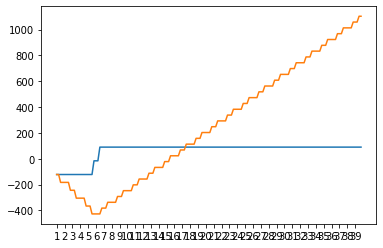

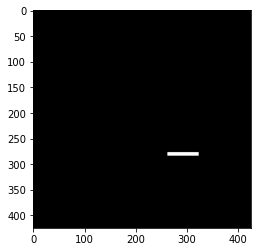

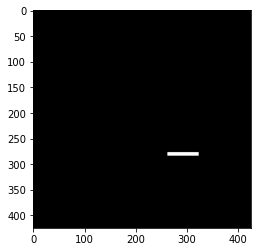

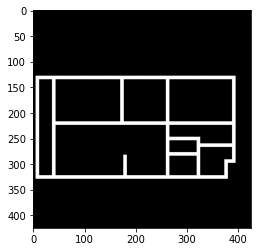

1
[6.19246545]


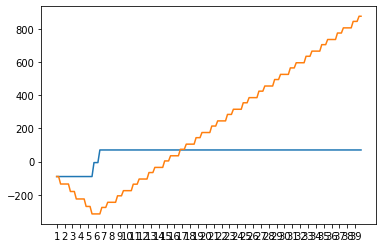

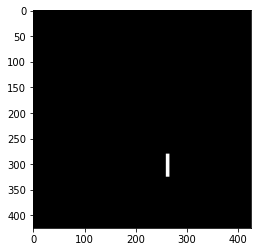

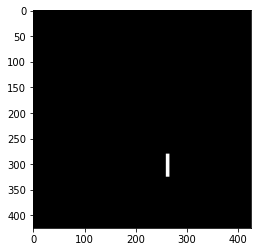

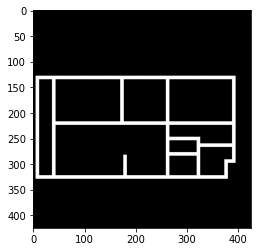

2
[5.75107459]


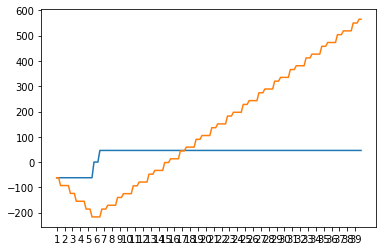

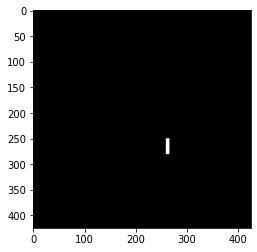

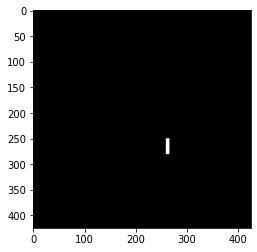

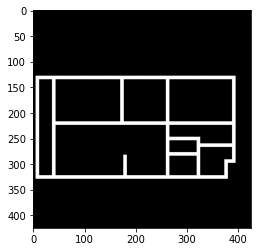

3
[5.97978173]


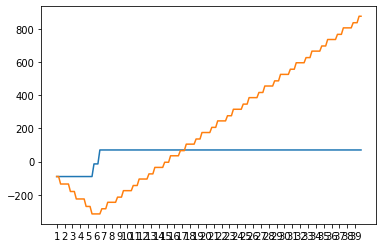

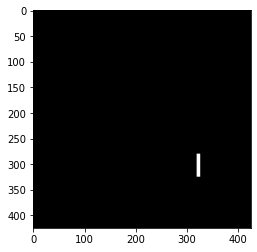

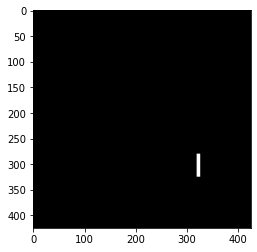

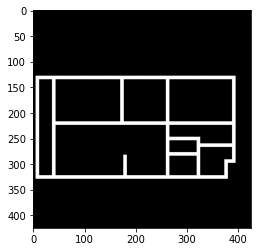

4
[5.96760166]


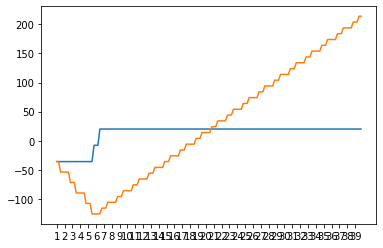

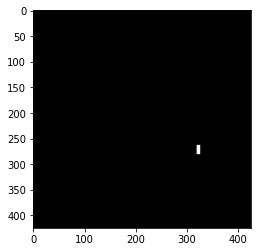

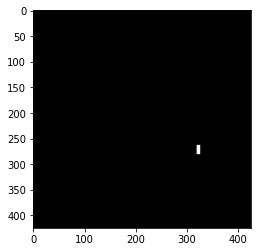

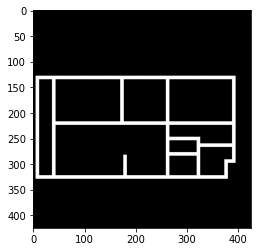

5
[8.41967199]


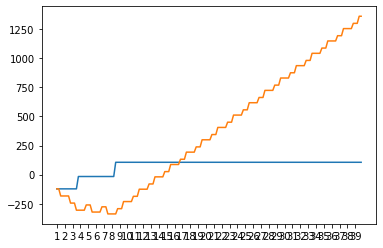

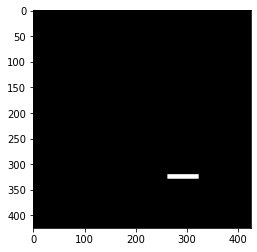

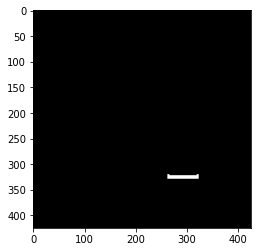

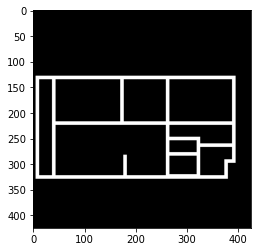

6
[9.65937825]


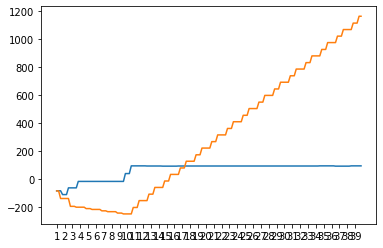

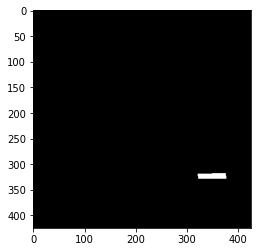

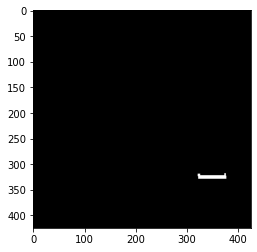

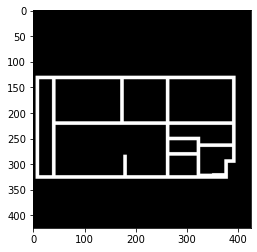

7
[8.1112006]


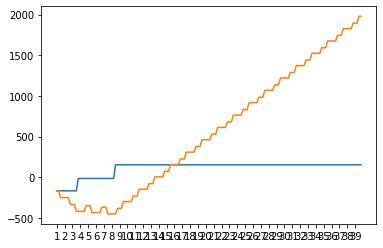

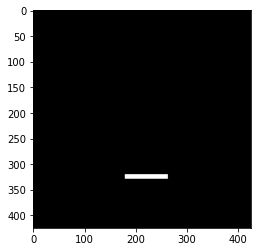

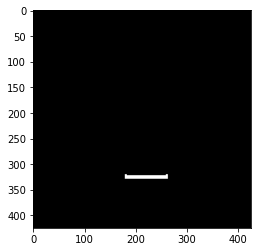

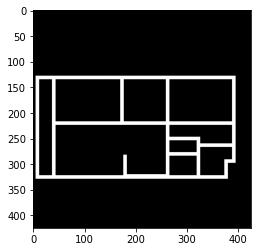

8
[5.80113719]


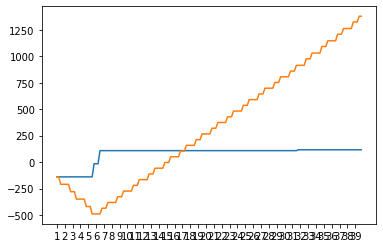

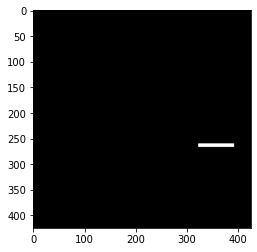

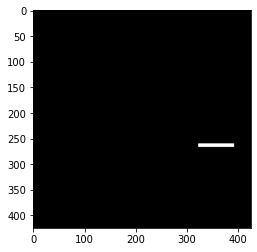

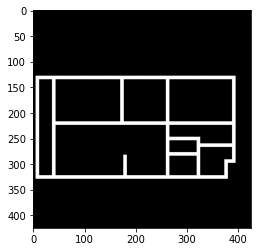

9
[6.42171958]


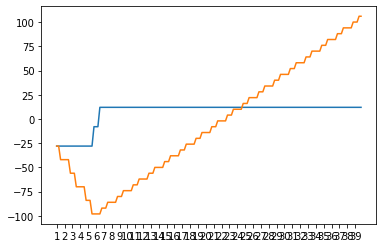

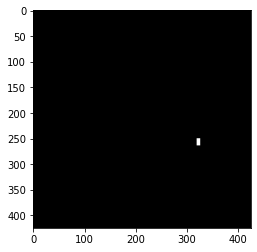

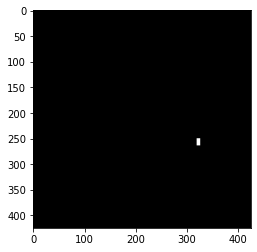

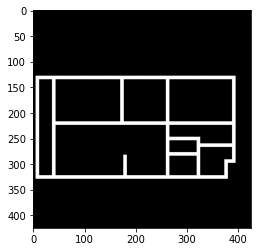

10
[6.44758613]


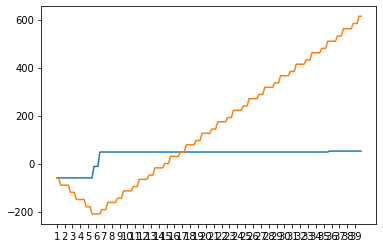

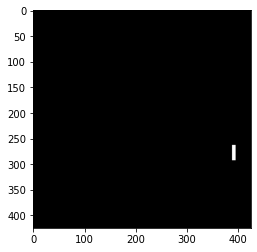

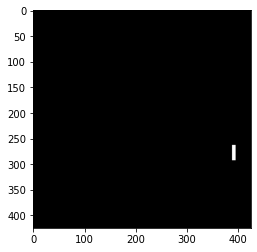

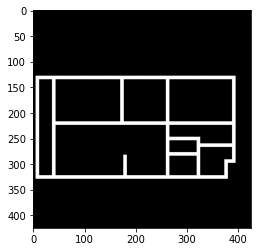

11
[5.65678769]


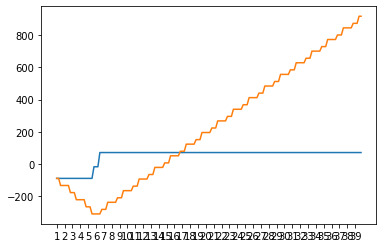

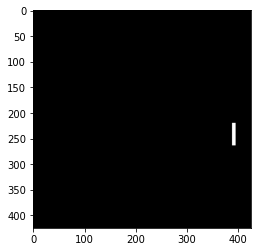

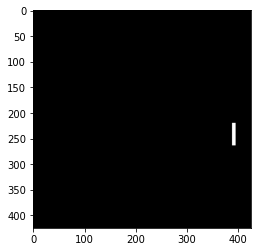

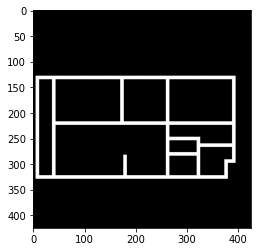

12
[8.17879737]


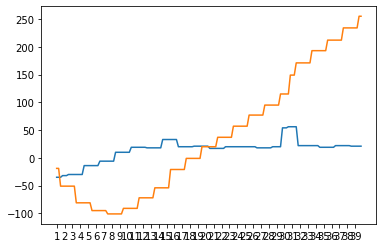

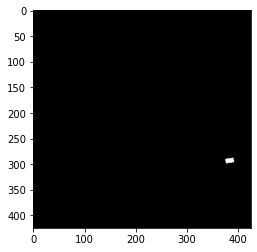

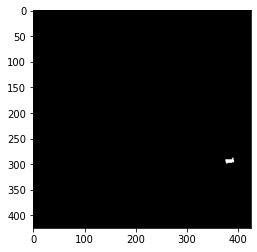

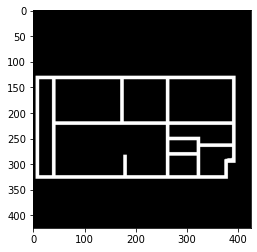

13
[5.94006792]


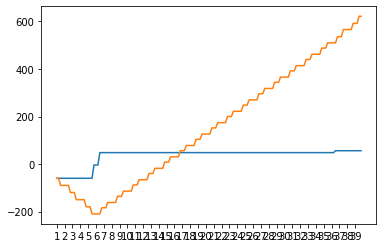

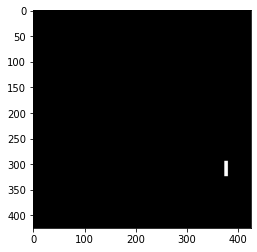

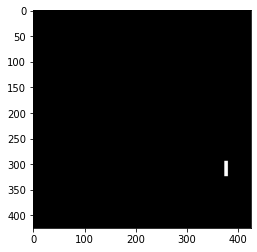

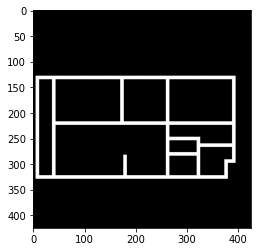

14
[7.28377714]


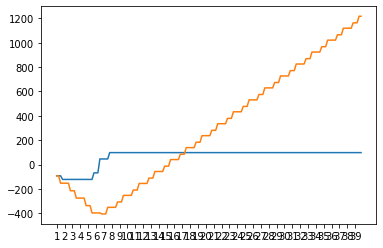

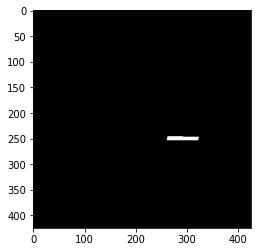

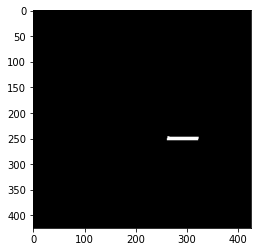

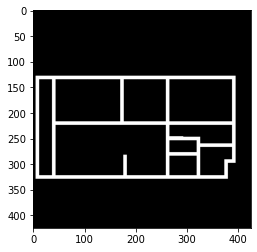

15
[5.61853203]


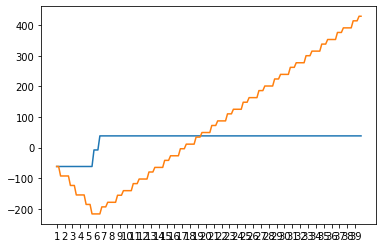

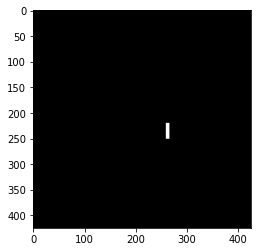

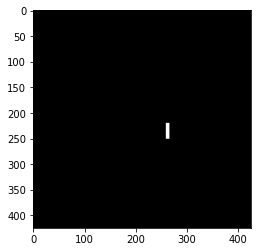

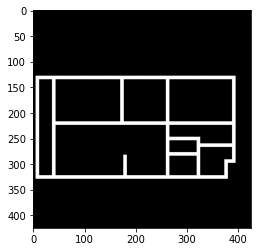

16
[6.12386574]


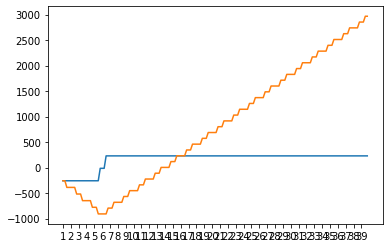

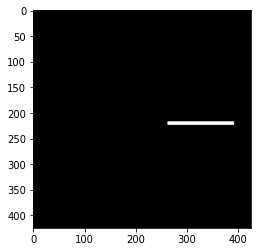

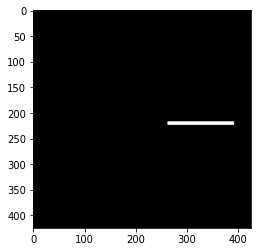

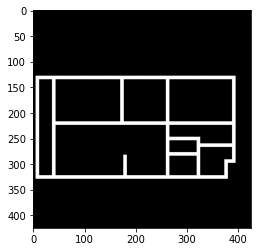

17
[5.99180323]


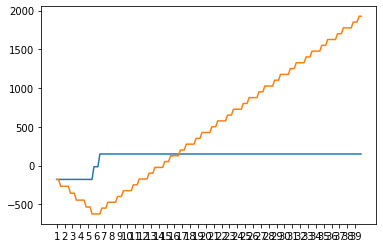

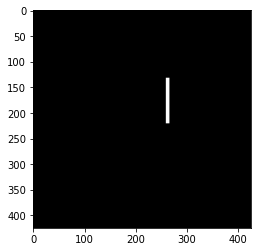

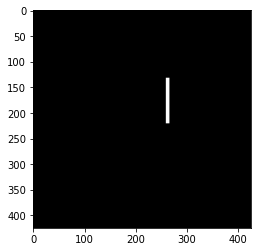

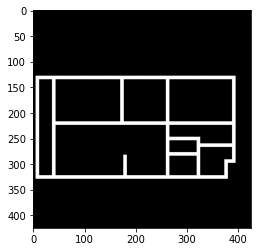

18
[8.28770722]


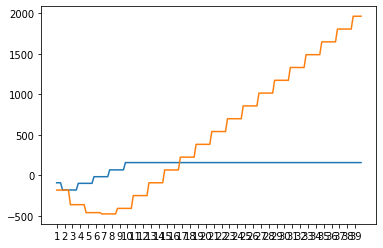

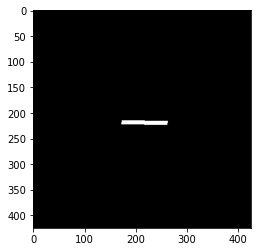

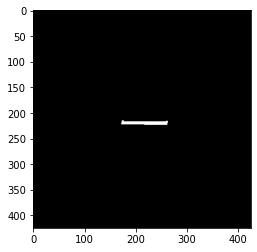

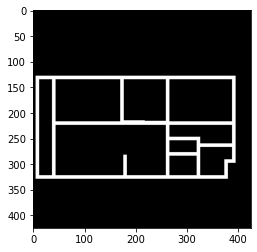

19
[6.34361643]


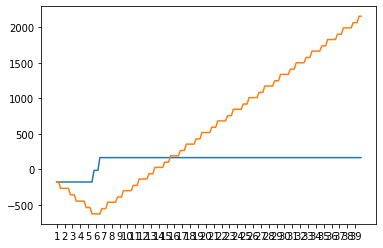

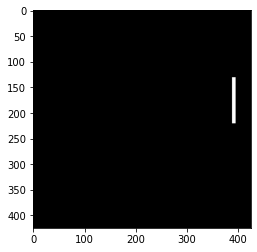

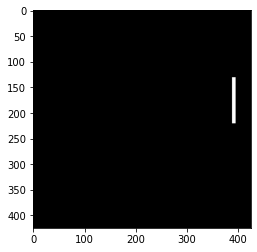

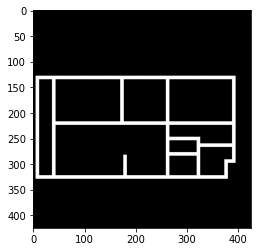

20
[6.13956245]


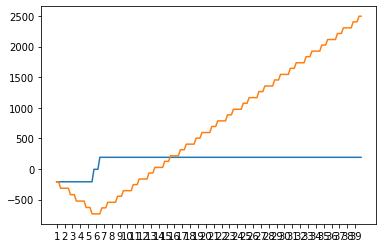

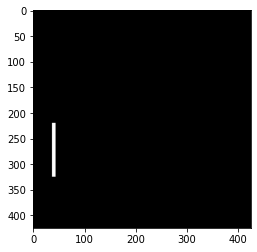

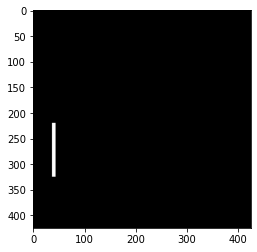

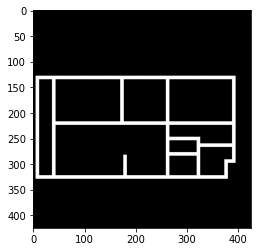

21
[7.72929168]


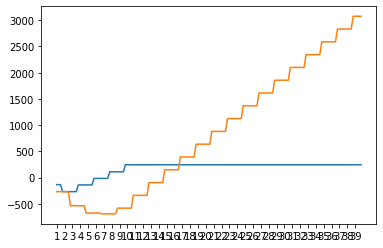

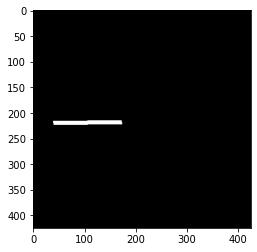

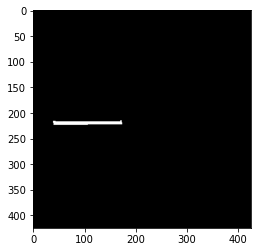

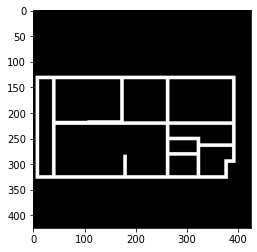

22
[5.99369678]


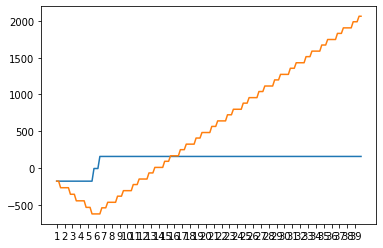

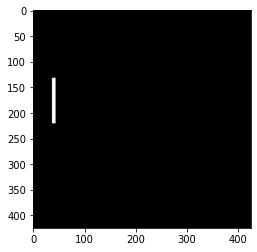

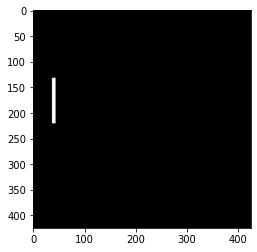

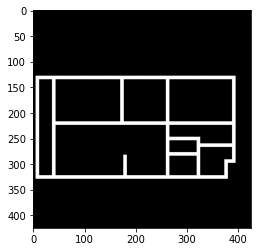

23
[5.7832313]


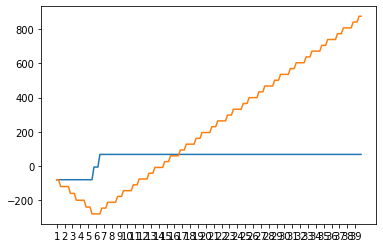

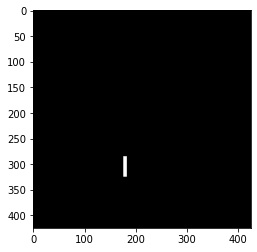

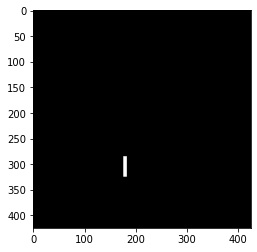

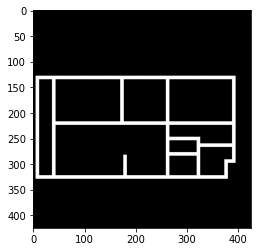

24
[8.23003367]


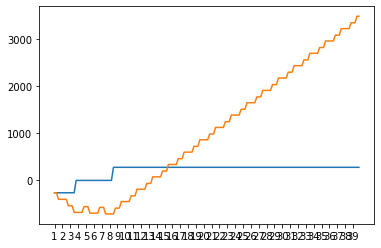

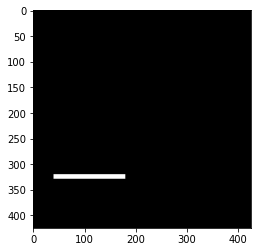

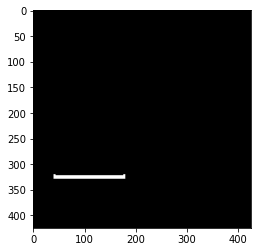

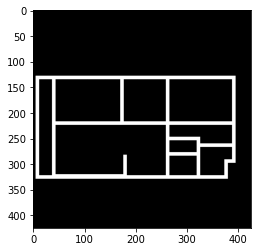

25
[9.17406575]


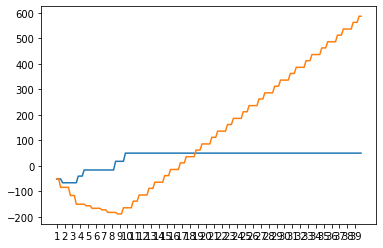

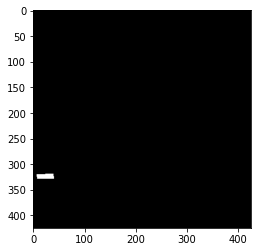

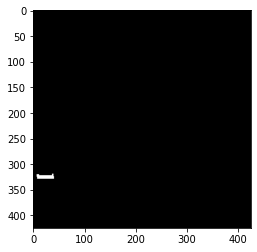

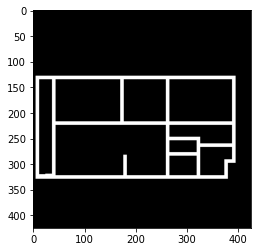

26
[7.04614021]


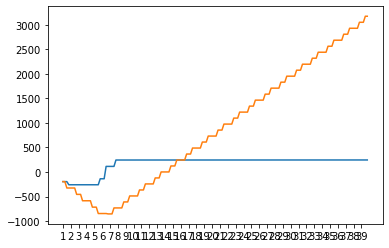

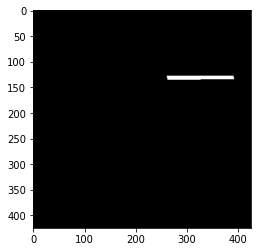

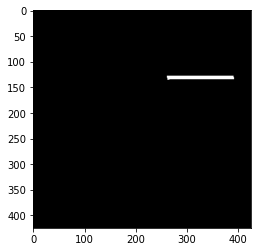

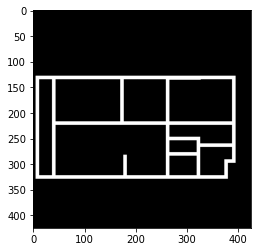

27
[7.42172487]


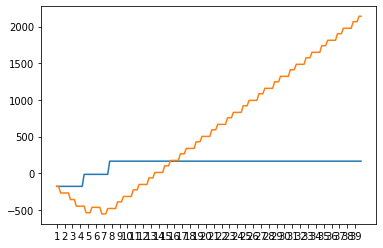

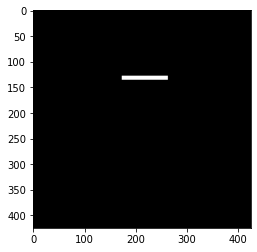

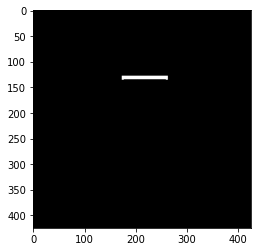

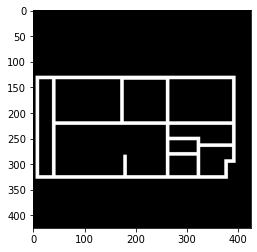

28
[6.40263905]


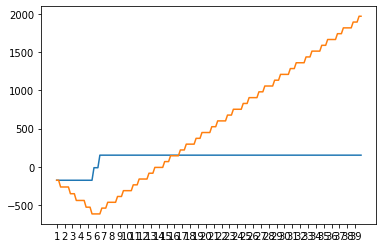

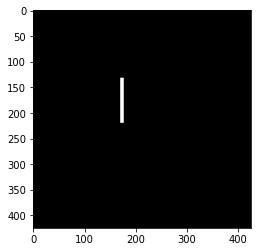

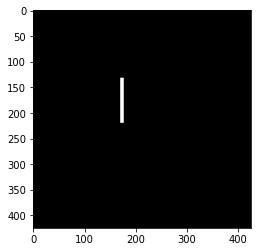

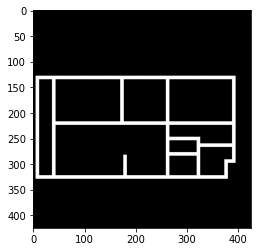

29
[6.90120833]


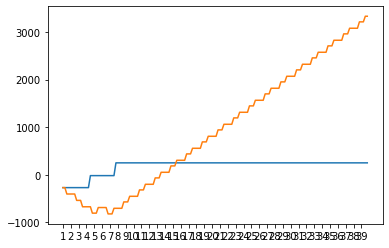

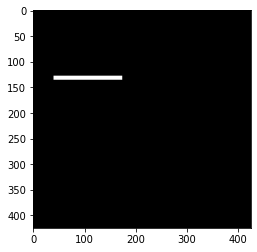

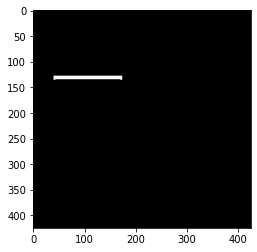

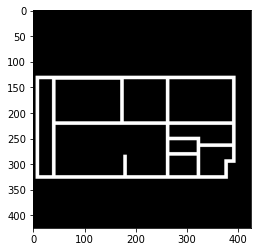

30
[7.31526826]


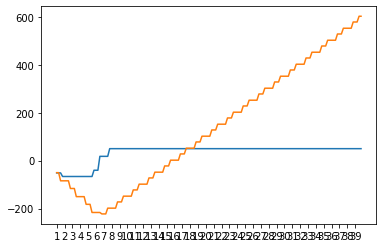

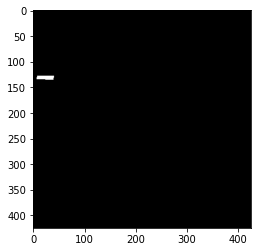

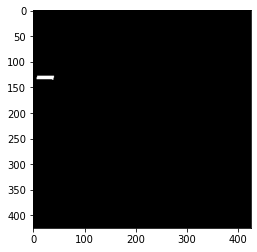

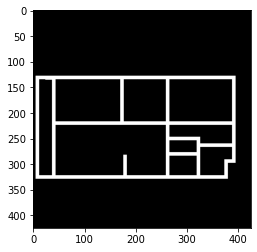

31
[5.83407117]


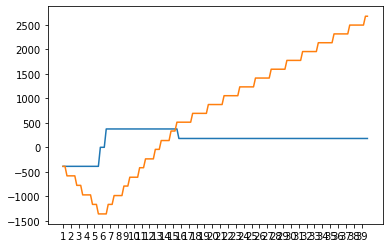

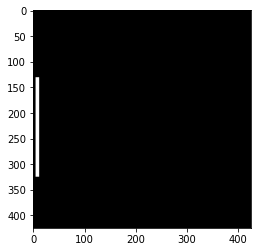

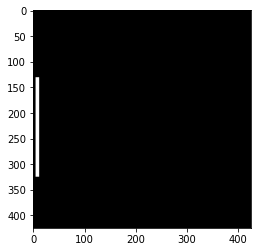

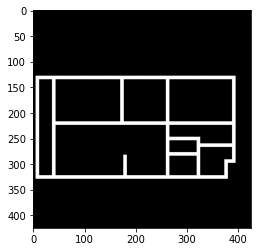

In [87]:
from scipy.optimize import differential_evolution, minimize

def jac(x, obj, h=1):
    return [(obj([x[0]+h]) - obj([x[0]-h]))/(h)]

def objective(x, wall, wallPixels):
    return -loss(wall, wallPixels, int(round(x[0])))

for i, w in enumerate(walls):
    print(i)
    o = lambda x: objective(x, w, wallPixels)
    solution = differential_evolution(o, bounds=[(1, 40)])
    #solution = minimize(lambda x: objective(x, walls[0], wallPixels), [20], jac=lambda x: jac(x, o, 1))
    print(solution.x)

    a = np.arange(1, 40, 0.25)
    y_values = np.array([o([x]) for x in a])
    jac_values = np.array([jac([x], o, 1) for x in a])
    plt.plot(a, jac_values)
    plt.plot(a, y_values)
    plt.xticks(np.arange(1, 40))
    plt.show()
    plotWallAndIOU(w, wallPixels, int(round(solution.x[0])))

In [13]:
n_comps, labels, stats, centroids = cv.connectedComponentsWithStats(doors_thresh, 8, cv.CV_32S)

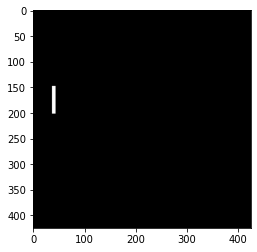

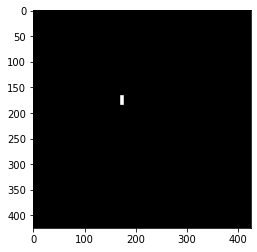

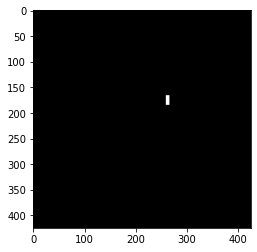

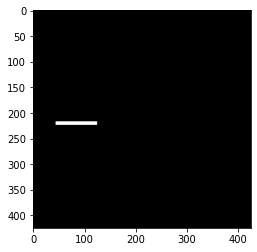

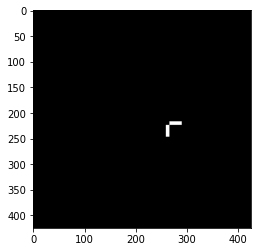

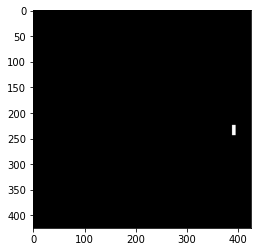

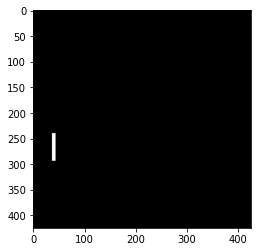

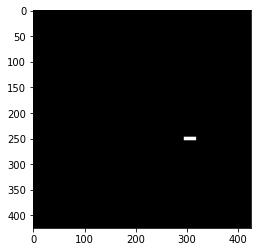

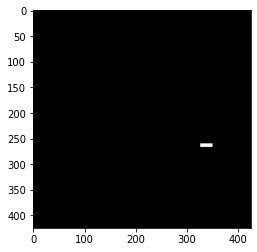

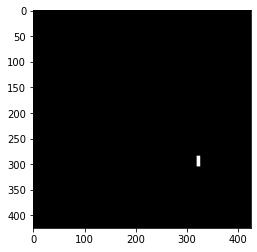

In [14]:
for l in range(1, n_comps):
    im = labels == l
    plt.imshow(im, cmap="gray")
    plt.show()

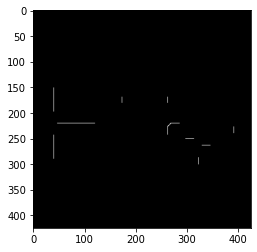

In [15]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

doors = cv.imread("1_close.png")
doors_gray = cv.cvtColor(doors, cv.COLOR_BGR2GRAY)
doors_thresh = cv.threshold(doors_gray, 0, 255, cv.THRESH_OTSU)[1]
skeleton = cv.ximgproc.thinning(doors_thresh)

plt.imshow(skeleton, cmap="gray")

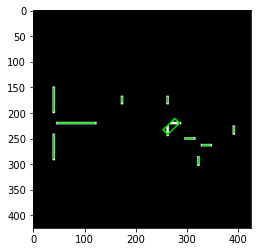

In [16]:
door_cnts, _ = cv.findContours(skeleton, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
im = np.expand_dims(eroded, axis=2).repeat(3, axis=2) 
for k, cnt in enumerate(door_cnts):
    rect = cv.minAreaRect(cnt)
    box = cv.boxPoints(rect)
    box = np.int0(box)
    im = cv.drawContours(im, [box], 0, (0, 220, 0), 2)
    
plt.imshow(im)